# Model Priors
In this notebook I will compare the different model priors that are imposed on inferred physical properties: ${\rm SSFR}$ and $Z_{\rm MW}$. The models we will compare are: 
- $\tau$ model
- delayed $\tau$ model
- Rita's 4 component NMF SFH basis 
- updated TNG 4 component NMF SFH basis
- updated TNG 4 component NMF SFH basis with burst 

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models
from astropy.cosmology import Planck13

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
np.random.seed(0)

In [4]:
def prior_tau(tage): 
    '''model priors for tau and delayed-tau models depend on the age.
    We set the fraction of mass from constant SFH to 0 and from bursts
    to 0 (i.e. I use the simple dust model)
    '''
    prior = Infer.load_priors([
        Infer.UniformPrior(0., 0.), 
        Infer.UniformPrior(0.3, 1e1), # tau SFH
        Infer.UniformPrior(0., 0.), # constant SFH
        Infer.UniformPrior(0., tage-1.), # start time
        Infer.UniformPrior(0., 0.),  # fburst
        Infer.UniformPrior(0., tage),  # tburst
        Infer.UniformPrior(1e-6, 1e-3), # metallicity
        Infer.UniformPrior(0., 4.)
    ])
    return prior

In [5]:
def prior_nmf(tage): 
    return Infer.load_priors([
        Infer.UniformPrior(0, 0, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
    ])

def prior_nmf_burst(tage): 
    return Infer.load_priors([
        Infer.UniformPrior(0, 0, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(0., 1.), # fburst 
        Infer.UniformPrior(0., tage), # tburst
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
    ])

In [6]:
models = [
    Models.FSPS(name='tau'), # tau model
    Models.FSPS(name='delayed_tau'), # delayed tau
    Models.FSPS(name='nmf_bases'), # 4 basis SFH
    Models.FSPS(name='nmf_tng4'),
    Models.FSPS(name='nmfburst')
]

# Comparison at a single redshift $z=0.01$

In [7]:
zred = 0.01
tage = Planck13.age(zred).value

In [8]:
priors = [
    prior_tau(tage), 
    prior_tau(tage), 
    prior_nmf(tage),
    prior_nmf(tage),
    prior_nmf_burst(tage)
]

In [9]:
n_sample = 10000 # draw n_sample samples from the prior

In [10]:
SSFRs_1gyr, Zmws, ts_sfh, sfhs = [], [], [], []
for i, model, prior in zip(range(len(models)), models, priors):
    _thetas = np.array([prior.sample() for i in range(n_sample)])
    thetas = prior.transform(_thetas)
    
    _ssfr_1gyr = model.avgSFR(thetas, zred, dt=1.)  
    _zmw = model.Z_MW(thetas, zred)
    
    SSFRs_1gyr.append(_ssfr_1gyr)
    Zmws.append(_zmw)

In [11]:
print([_ssfr.max() for _ssfr in SSFRs_1gyr])

[9.988710201521651e-10, 9.99999464481749e-10, 2.2475109238530436e-10, 7.910481797379068e-10, 9.998746196105318e-10]


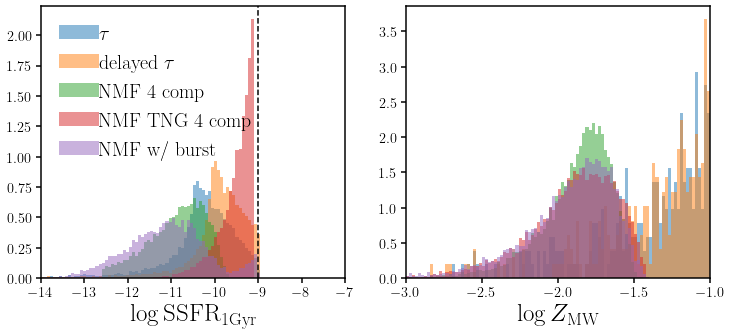

In [13]:
model_labels = [r'$\tau$', r'delayed $\tau$', 'NMF 4 comp', 'NMF TNG 4 comp', 'NMF w/ burst']

props = [SSFRs_1gyr, Zmws]
lbls = [r'$\log {\rm SSFR}_{\rm 1 Gyr}$', r'$\log Z_{\rm MW}$']
rngs = [(-14, -7), (-3, -1)]

fig = plt.figure(figsize=(12,5))
for i, prop in enumerate(props): 
    sub = fig.add_subplot(1,2,i+1)
    for ii, prop_i in enumerate(prop): 
        sub.hist(np.log10(prop_i), density=True, range=rngs[i], bins=100, alpha=0.5, label=model_labels[ii])
    if i == 0: 
        sub.legend(loc='upper left', handletextpad=0, fontsize=20)
        sub.axvline(-9., color='k', ls='--')
    sub.set_xlabel(lbls[i], fontsize=25)
    sub.set_xlim(rngs[i])

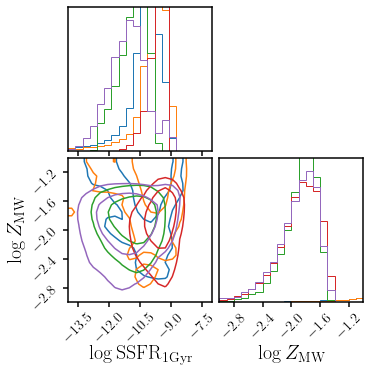

In [14]:
fig = None
for i in range(len(models)): 
    fig = DFM.corner(np.log10(np.array(props)[:,i,:].T), 
                     levels=[0.68, 0.95],
                     smooth=True, 
                     color='C%i' % i, 
                     range=rngs, 
                     labels=lbls,
                     label_kwargs={'fontsize': 20}, 
                     fig=fig, 
                     plot_datapoints=False, fill_contours=False, plot_density=False
                    )

Overall the NMF and compressed NMF models impose more restrictive priors on $\log {\rm SSFR}$ and $\log Z_{\rm MW}$

# redshift dependence of model priors

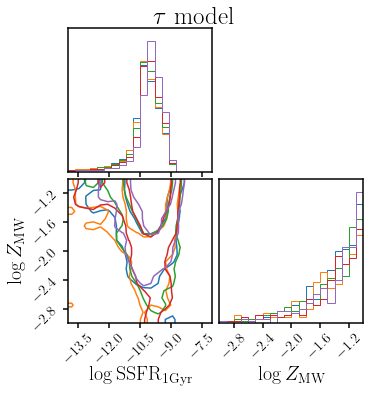

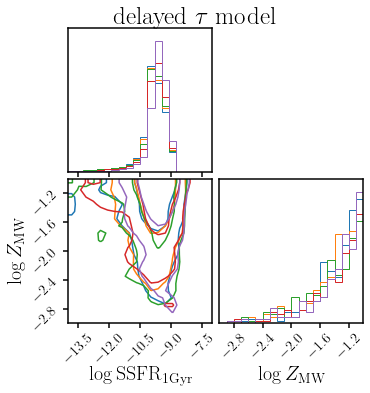

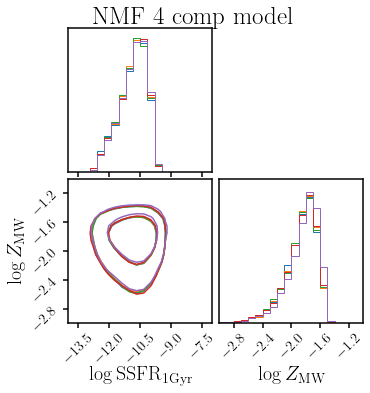

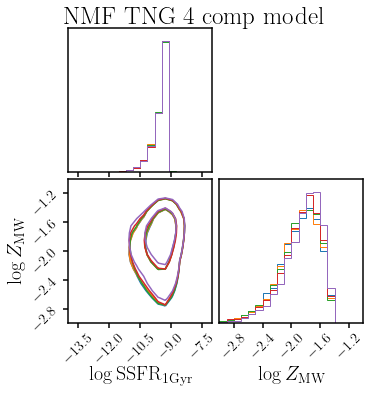

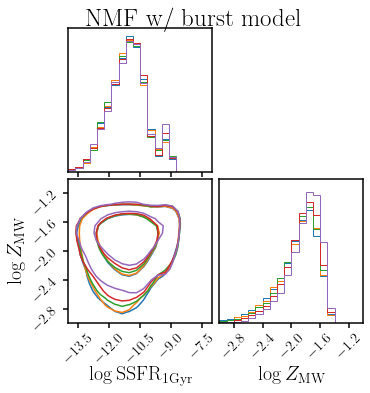

In [16]:
prior_fns = [prior_tau, prior_tau, prior_nmf, prior_nmf, prior_nmf_burst]
for model, prior_fn, lbl in zip(models, prior_fns, model_labels):
    
    fig = None
    for i_z, zred in enumerate([0.01, 0.05, 0.1, 0.2, 0.4]): 
        tage = Planck13.age(zred).value
        prior = prior_fn(tage)
        _thetas = np.array([prior.sample() for i in range(n_sample)]) 
        thetas = prior.transform(_thetas)

        _ssfr_1gyr = model.avgSFR(thetas, zred, dt=1.)    
        _zmw = model.Z_MW(thetas, zred)

        fig = DFM.corner(np.log10(np.array([_ssfr_1gyr, _zmw])).T, 
                         levels=[0.68, 0.95],
                         smooth=True, 
                         range=rngs, 
                         labels=lbls,
                         label_kwargs={'fontsize': 20}, 
                         color='C%i' % i_z, 
                         fig=fig,
                         plot_datapoints=False, fill_contours=False, plot_density=False
                        )
    fig.suptitle(lbl+' model', fontsize=25)

None of the models have significant redshift dependence. 

## prior on recovered SFH

In [17]:
zred = 0.01
tage = Planck13.age(zred).value
recov_sfhs = []
for model, prior_fn in zip(models, prior_fns):
    prior = prior_fn(tage)
    _thetas = np.array([prior.sample() for i in range(n_sample)]) 
    thetas = prior.transform(_thetas)    
    
    recov_sfh = [model.avgSFR(thetas, zred, dt=1.)]    
    for tlb in np.arange(1, 11): 
        recov_sfh.append(model.avgSFR(thetas, zred, dt=1., t0=tlb))
    recov_sfhs.append(recov_sfh)

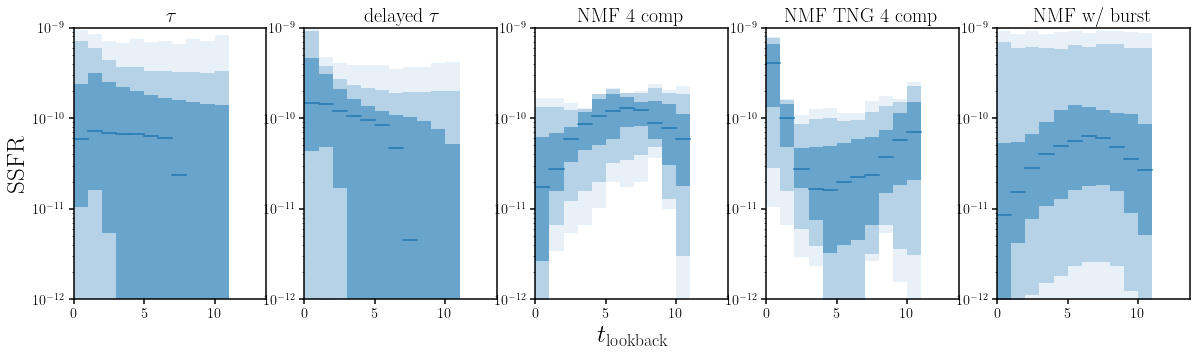

In [18]:
fig = plt.figure(figsize=(20,5))
for i, recov_sfh in enumerate(recov_sfhs):
    sub = fig.add_subplot(1, len(recov_sfhs), i+1)
    for tlb, rsfh in zip(np.arange(11) + 0.5, recov_sfh): 
        lll, ll, l, m, h, hh, hhh = np.quantile(rsfh, [0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995])
        sub.fill_between([tlb-0.5, tlb+0.5], [lll, lll], [hhh, hhh], color='C0', alpha=0.1, linewidth=0)
        sub.fill_between([tlb-0.5, tlb+0.5], [ll, ll], [hh, hh], color='C0', alpha=0.25, linewidth=0)
        sub.fill_between([tlb-0.5, tlb+0.5], [l, l], [h, h], color='C0', alpha=0.5, linewidth=0)
        sub.plot([tlb-0.5, tlb+0.5], [m, m], c='C0', ls='-')
    if i == 0: sub.set_ylabel('SSFR', fontsize=25)
    else: sub.set_yticklabels([])
    sub.set_yscale('log')
    sub.set_ylim(1e-12, 1e-9)
    if i == 2: sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
    sub.set_xlim(0, tage)
    sub.set_title(model_labels[i], fontsize=20)